# Quickstart

In [1]:
from optiwindnet.importer import load_repository
from optiwindnet.svg import svgplot
from optiwindnet.interarraylib import G_from_S
from optiwindnet.mesh import make_planar_embedding
from optiwindnet.pathfinding import PathFinder

In [2]:
locations = load_repository()

## Quickest (sub-second)

In [3]:
from optiwindnet.heuristics import EW_presolver

In [4]:
L = locations.doggerA

In [5]:
%%timeit
P, A = make_planar_embedding(L)

56.3 ms ± 9.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
P, A = make_planar_embedding(L)

In [7]:
%%timeit
S_pre = EW_presolver(A, capacity=8)

7.2 ms ± 561 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
S_pre = EW_presolver(A, capacity=8)

In [9]:
%%timeit
G_tentative = G_from_S(S_pre, A)
G_pre = PathFinder(G_tentative, planar=P, A=A).create_detours()

53.8 ms ± 6.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
G_tentative = G_from_S(S_pre, A)
G_pre = PathFinder(G_tentative, planar=P, A=A).create_detours()

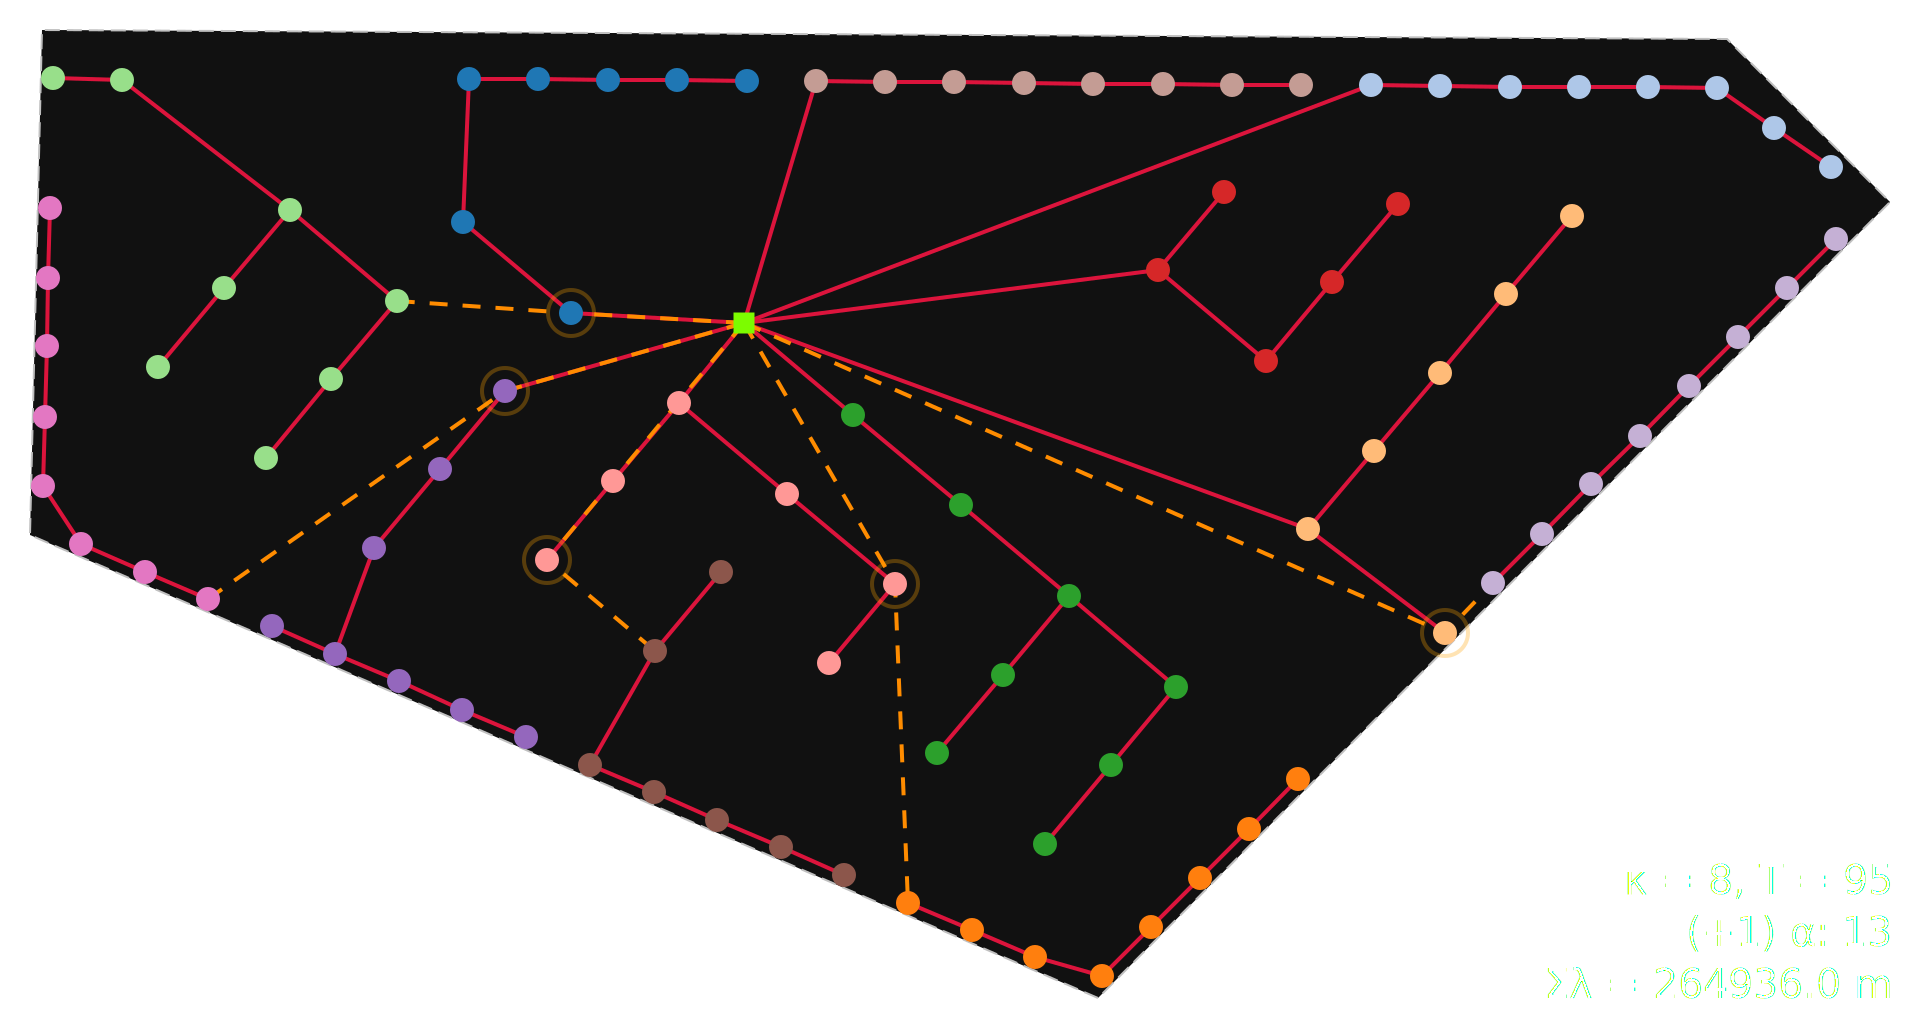

In [11]:
svgplot(G_pre)

## Quick (radial only, a second or two)

In [12]:
from optiwindnet.baselines.hgs import iterative_hgs_cvrp
from optiwindnet.interarraylib import as_normalized

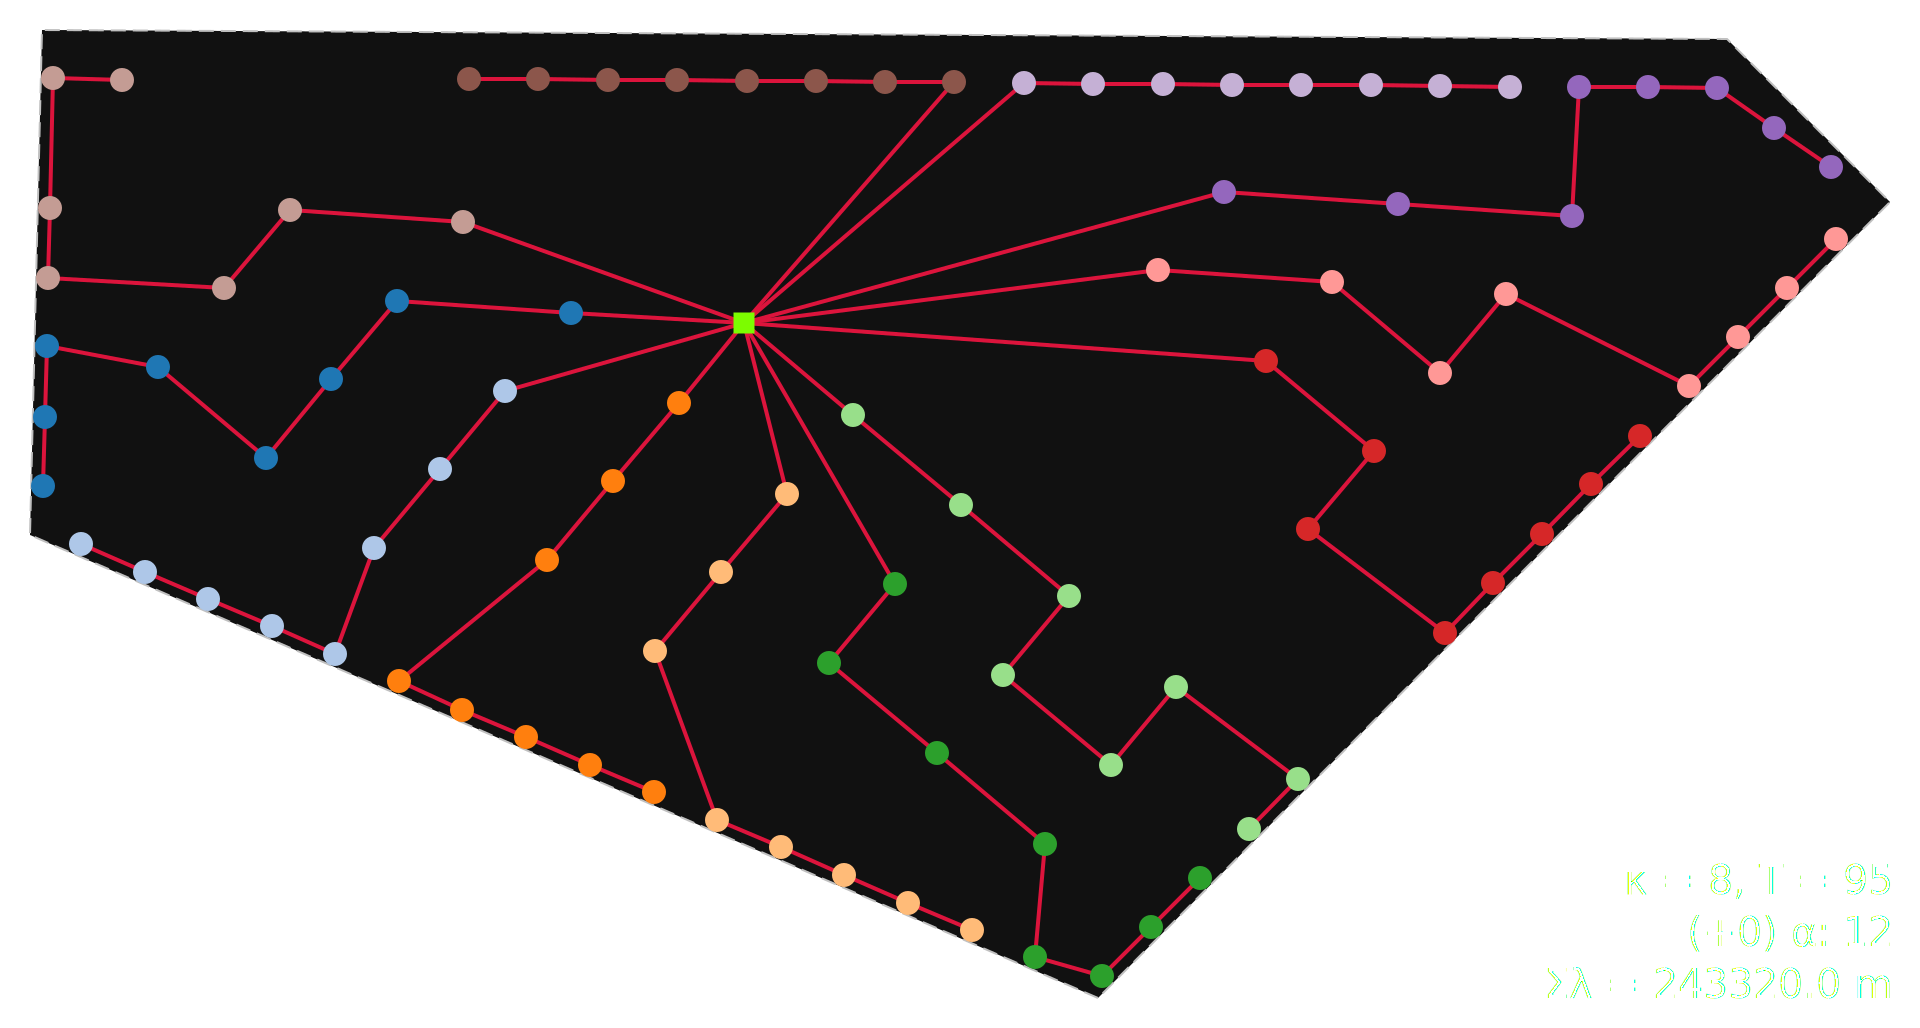

In [13]:
L = locations.doggerA
P, A = make_planar_embedding(L)
Aʹ = as_normalized(A)
S_hgs = iterative_hgs_cvrp(Aʹ, capacity=8, time_limit=2)
G_tentative = G_from_S(S_hgs, A)
G_hgs = PathFinder(G_tentative, planar=P, A=A).create_detours()
svgplot(G_hgs)

## With quality assurance (a few minutes)

In [17]:
import optiwindnet.MILP.ortools as ort

In [18]:
model = ort.make_min_length_model(
    A, S_hgs.graph['capacity'],
    gateXings_constraint=False,
    gates_limit=False,
    branching=True
)
ort.warmup_model(model, S_hgs);

In [19]:
orter = ort.cp_model.CpSolver()

In [20]:
orter.parameters.max_time_in_seconds = 300
orter.parameters.relative_gap_limit = 0.03
orter.parameters.num_workers = 16

# be verbose
orter.parameters.log_search_progress = True
# required to get the log inside the notebook (goes only to console otherwise)
orter.log_callback = print

result = orter.solve(model)

gap = 1 - orter.BestObjectiveBound()/orter.ObjectiveValue()
print('=================================================================',
      #orter.ResponseStats(),  # uncomment if orter.parameters.log_search_progress == False
      f"\nbest solution's strategy: {orter.SolutionInfo()}",
      f'\ngap: {100*gap:.1f}%')


Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 300 log_search_progress: true relative_gap_limit: 0.03 num_workers: 16

Initial optimization model 'Dogger Bank A': (model_fingerprint: 0x244dc747512339a0)
#Variables: 1'690 (#bools: 470 in floating point objective)
  - 1'220 Booleans in [0,1]
  - 375 in [-7,7]
  - 95 in [0,8]
#kAtMostOne: 355 (#literals: 1'433)
#kLinear1: 2'440 (#enforced: 2'440)
#kLinearN: 98 (#terms: 1'505)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 470 terms with magnitude in [1409.66, 22631.9] average = 5308.26
[Scaling] Objective coefficient relative error: 3.33118e-10
[Scaling] Objective worst-case absolute error: 6.13691e-05
[Scaling] Objective scaling factor: 1.04858e+06
  6.08e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.72e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  8.75e-05s  0.00e+00d  [

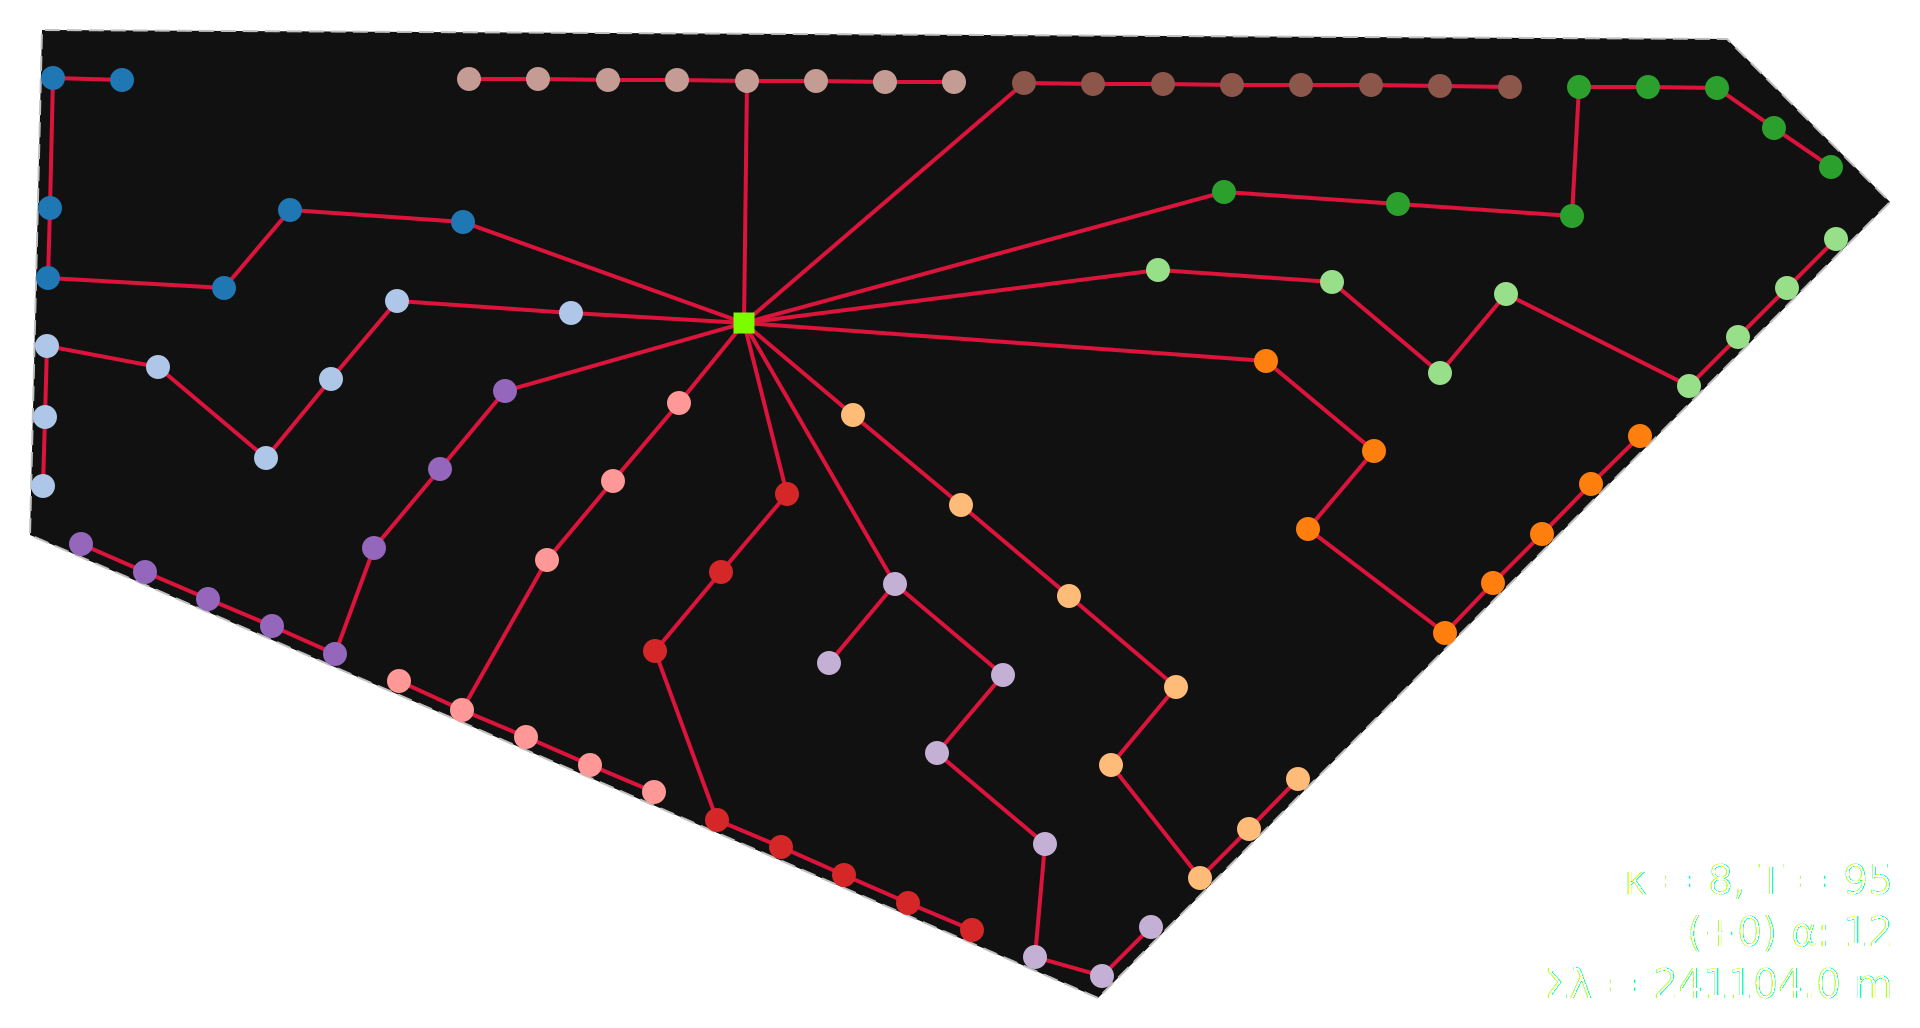

In [21]:
S = ort.S_from_solution(model, orter, result)
G_tentative = G_from_S(S, A)
G = PathFinder(G_tentative, planar=P, A=A).create_detours()
svgplot(G)